In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import scipy.constants as const
from beam.beams import electronbeam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
from beam import interactions
from lens import profile
from scipy.interpolate import interp1d
import beam.calc.electron as ecalc

path = '/media/robert/Data_Storage/Data/Super-Adiabatic_Ramp_Propagation/Analytic_Emittance_Growth/'

In [2]:
z0 = 0.0
dz = 0.5
betas = 0.1
waist = 0.0
hw = 0.14
Nz = 3000
sigma = hw/(np.sqrt(2*np.log(2)))
#beta0 = betas+(z0+waist)**2/betas
#alpha0 = (z0+waist)/betas
beta0 = betas
alpha0 = 0
Z = 2*z0+dz
gb0 = 20000
ne0 = 0.5
z, frac = profile.plasma_gaussian_ramps(z0, dz, sigma, sigma, Nz, Z)
ne = frac*ne0
z *= 1e6
class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        return 0.0
plasmaDen = plasmaCls()
# Create the electron beam
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : gb0,
    'emittance' : 7e-6,
    'betax' : beta0,
    'betay' : beta0,
    'alphax' : alpha0,
    'alphay' : alpha0,
    'sigmaz' : 5e-6,
    'dE' : 0.05
}

beam = electronbeam.GaussianElectronBeam(electronParams)
dumpPer = 4
interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 4)
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, Z, m)
beam_ne = ne[0::4]
# Let,s also propagate the CS parameters through the plasma
CSbeta, CSalpha, CSgamma, CSgb = ecalc.cs_propagation(z*1e-6, ne, beta0, alpha0, gb0, 0, ne0)
CSbeta = CSbeta[0::4]

In [3]:
# Check to make sure everything seems correct
beam_sigmar = np.zeros(m, dtype='double')
beam_sigmarp = np.zeros(m, dtype='double')
beam_eps = np.zeros(m, dtype='double')
for i in range(m):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))
    beam_sigmarp[i] = np.average(beam.get_sigmarp(i))
    beam_eps[i] = np.average(beam.get_emittance_n(i))
beam_beta = (beam_sigmar)**2 / beam_eps * gb0
beam_gamma = (beam_sigmarp)**2 / beam_eps * gb0
matched_beta = np.sqrt(2*gb0) / (5.95074e4 * np.sqrt(0.5))
print('Initial emittance: %0.4f um rad' % (beam_eps[0]*1e6))
print('Final emittance:   %0.4f um rad' % (beam_eps[m-1]*1e6))
print(matched_beta)

Initial emittance: 6.9725 um rad
Final emittance:   72.0073 um rad
0.00475306789533


/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


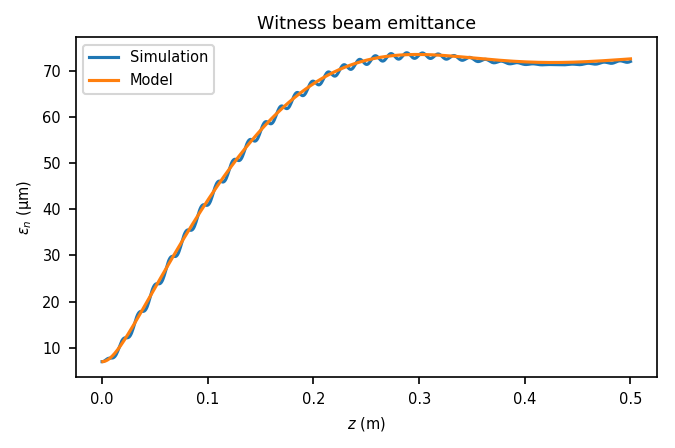

In [4]:
bF = matched_beta
match_exp = bF/betas + betas/bF
eps_sat = beam_eps[0]*(matched_beta/betas+betas/matched_beta)/2
Psimax = beam_z/(np.sqrt(0.95)*bF)
Psimin = beam_z/(np.sqrt(1.05)*bF)
DeltaPsi = Psimax-Psimin
eps = eps_sat*np.sqrt(1-(match_exp**2-4)/match_exp**2*(np.sin(DeltaPsi)/DeltaPsi)**2)
#eps = eps_sat*np.sqrt(1-(np.sin(DeltaPsi)/DeltaPsi)**2)

plt.figure(figsize=(5, 3), dpi=150)
plt.plot(beam_z, beam_eps*1e6)
plt.plot(beam_z, eps*1e6)
plt.title('Witness beam emittance')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\epsilon_n$ ($\mathrm{\mu m}$)')
plt.legend(['Simulation', 'Model'])
#plt.twinx()
#plt.plot(beam_z, CSbeta, beam_z, beam_beta)
plt.show()

In [5]:
# Lets look at the emittance saturation as a function of mismatch
Na = 15
beta0 = 0.00475306789533
alpha0 = np.linspace(0, 10.0, Na)
a_eps = np.empty(Na, dtype='double')
for i in range(Na):
    print('Iteration', i)
    electronParams['name'] = 'beta-%0.2f_alpha-%0.2f' % (beta0, alpha0[i])
    electronParams['betax'] = beta0,
    electronParams['betay'] = beta0,
    electronParams['alphax'] = alpha0[i],
    electronParams['alphay'] = alpha0[i],
    beam = electronbeam.GaussianElectronBeam(electronParams)
    interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 4)
    a_eps[i] = np.average(beam.get_emittance_n(625))/np.average(beam.get_emittance_n(0))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14


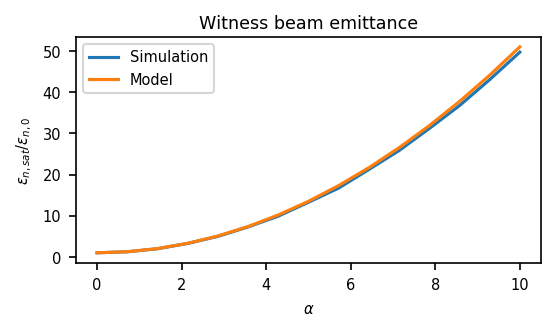

In [6]:
plt.figure(figsize=(4, 2), dpi=150)
plt.plot(alpha0, a_eps, alpha0, 1+alpha0**2/2)
plt.title('Witness beam emittance')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\epsilon_{n,sat}/\epsilon_{n,0}$')
plt.legend(['Simulation', 'Model'])
plt.show()

In [7]:
# Let's build a small test case in nondimensional coordinates with a not perfect ramp
f = lambda z: 1 - 1/(1+(z/L)**(3+P))
fp = lambda z: (3+P)*(z/L)**(2+P)/(1+(z/L)**(3+P))**2/L
fpp = lambda z: -2*(3+P)**2*(z/L)**(4+2*P)/(1+(z/L)**(3+P))**3/L**2 \
                + (3+P)*(2+P)*(z/L)**(1+P)/(1+(z/L)**(3+P))**2/L**2

g = lambda z: (z-z0)**2/bs + bs - 1
gp = lambda z: 2*(z-z0)/bs
gpp = lambda z: 2/bs

b = lambda z: 1 + g(z)*f(z)
bp = lambda z: g(z)*fp(z) + gp(z)*f(z)
bpp = lambda z: g(z)*fpp(z)+2*gp(z)*fp(z)+gpp(z)*f(z)

ne = lambda z: 1/(b(z)**2)*(1+bp(z)**2/4)-bpp(z)/(2*b(z))

epssat = lambda z: 1/(2*np.sqrt(ne(z)))*(0.5*bpp(z)+(1+ne(z))*b(z))

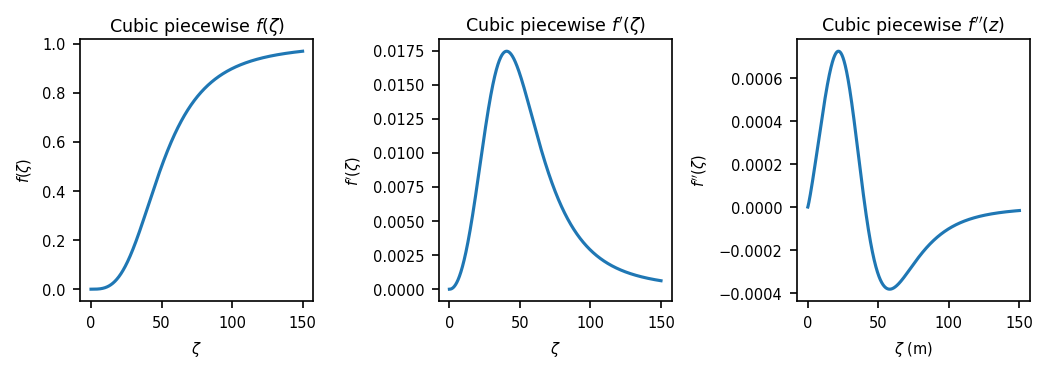

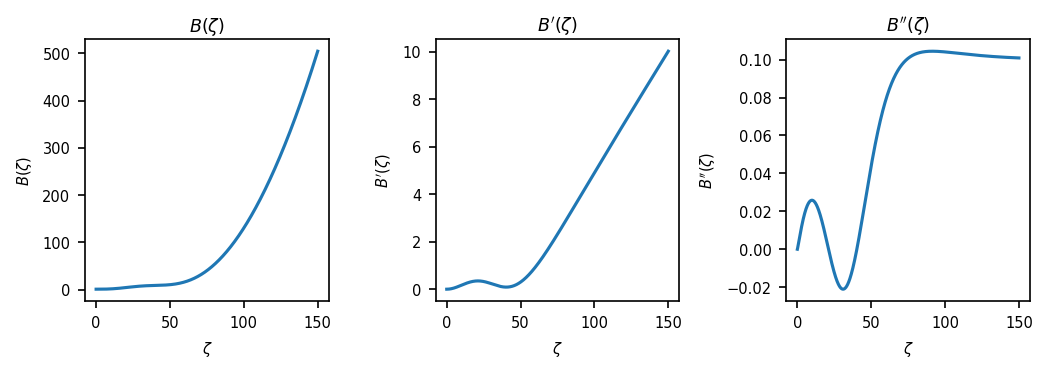

In [8]:
Nz = 10000
Z = 150
L = 50
P = 0.15
bs = 20
z0 = 50
z, dz = np.linspace(0, Z, Nz, retstep=True)
plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
plt.plot(z, f(z))
plt.title(r"Cubic piecewise $f(\zeta)$")
plt.xlabel(r'$\zeta$')
plt.ylabel(r"$f(\zeta)$")

plt.subplot(gs[0, 1])
plt.plot(z, fp(z))
plt.title(r"Cubic piecewise $f'(\zeta)$")
plt.xlabel(r'$\zeta$')
plt.ylabel(r"$f'(\zeta)$")

plt.subplot(gs[0, 2])
plt.plot(z, fpp(z))
plt.title(r"Cubic piecewise $f''(z)$")
plt.xlabel(r'$\zeta$ (m)')
plt.ylabel(r"$f''(\zeta)$")

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
plt.plot(z, b(z))
plt.title(r"$B(\zeta)$")
plt.xlabel(r'$\zeta$')
plt.ylabel(r"$B(\zeta)$")

plt.subplot(gs[0, 1])
plt.plot(z, bp(z))
plt.title(r"$B'(\zeta)$")
plt.xlabel(r'$\zeta$')
plt.ylabel(r"$B'(\zeta)$")

plt.subplot(gs[0, 2])
plt.plot(z, bpp(z))
plt.title(r"$B''(\zeta)$")
plt.xlabel(r'$\zeta$')
plt.ylabel(r"$B''(\zeta)$")

plt.tight_layout()
plt.show()

In [9]:
kb = (5.95074e4 * np.sqrt(0.5)) / np.sqrt(2*gb0)
Nz = 3000
beta0 = betas
alpha0 = 0
gb0 = 20000
ne0 = 0.5
z
z *= 1e6
class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        return 0.0
plasmaDen = plasmaCls()
# Create the electron beam
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : gb0,
    'emittance' : 7e-6,
    'betax' : beta0,
    'betay' : beta0,
    'alphax' : alpha0,
    'alphay' : alpha0,
    'sigmaz' : 5e-6,
    'dE' : 0.05
}

beam = electronbeam.GaussianElectronBeam(electronParams)
dumpPer = 4
interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 4)
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, Z, m)
beam_ne = ne[0::4]
# Let,s also propagate the CS parameters through the plasma
CSbeta, CSalpha, CSgamma, CSgb = ecalc.cs_propagation(z*1e-6, ne, beta0, alpha0, gb0, 0, ne0)
CSbeta = CSbeta[0::4]